# Interpolation
___

**Remarks**
- Code will need to be modified a bit to reflect the use of a certain group of data instead of all data

In [134]:
import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from itertools import combinations

# from scipy.spatial.distance import pdist
# from scipy.stats import chisquare, chi2
from scipy.stats import ttest_1samp, t

from pykrige.ok import OrdinaryKriging
from pykrige.rk import Krige
import pykrige.kriging_tools as kt

from sklearn.model_selection import cross_val_predict

from joblib import Parallel, delayed
import multiprocessing

In [135]:
import prepostprocessing.pre_processing as preproc
import prepostprocessing.post_processing as postproc
import nugget_estimation.kriging_tools as krigingtools
import nugget_estimation.detrending as detrending
import plots.plots as plots
import prepostprocessing.cleaning as cleaning
import cross_validation.leave_one_out_cross_validation as loocv

# import qapf.qapf as qapf
# import statistics.ttest as ttest
# import statistics.simulations as sim

import toolbox.toolbox as tb

In [136]:
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readtheMLcs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Remark below**

In [137]:
coordinates_latlon = preproc.load_obj("coordinates_area1")
coordinates_utm = preproc.load_obj("coordinates_utm_area1")
mineralogy = preproc.load_obj("mineralogy_area1")
mineralogy_clr = preproc.load_obj("mineralogy_clr_area1")
mineralogy_pca = preproc.load_obj("mineralogy_pca_area1")
mineralogy_pca_df = preproc.load_obj("mineralogy_pca_area1_df")
metadata = preproc.load_obj("metadata_area1")

## EDA
___

In [138]:
# Get number of control points that will be used
number_of_control_points = coordinates_utm.shape[0]
number_of_control_points

1623

In [139]:
coordinates_utm

,Y_UTM,X_UTM,ZoneNumber,ZoneLetter
2,1.821304e+06,6.200334e+06,47,T
6,1.535769e+06,5.720307e+06,47,T
9,1.494703e+06,5.662488e+06,47,T
10,1.517477e+06,5.756850e+06,47,T
11,1.327736e+06,5.680588e+06,47,T
...,...,...,...,...
4538,1.706776e+06,5.987460e+06,47,T
4552,1.719856e+06,6.116532e+06,47,T
4574,1.805569e+06,6.115360e+06,47,T
4585,1.850992e+06,6.089365e+06,47,T


In [140]:
coordinates_utm = coordinates_utm.rename({"X_UTM": "Y", "Y_UTM": "X"}, axis=1)

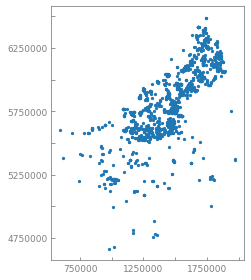

In [141]:
# FILL IN SHORT NAME HERE THAT WILL BE USED WHEN SAVING THE PLOT (e.g. "G1")
group_name = "area1"

# Plot control points with labels
plots.plot_map_with_control_points(coordinates_utm, group_name, label_size=4, subset=["X", "Y"],
                                   show_labels=False,
                                  skip_xaxis_label=2, skip_yaxis_label=2, 
                                  skip_xaxis_start=1, skip_yaxis_start=1)

In [142]:
# Show unique zone letters and zone numbers of utm coordinates
coordinates_utm["ZoneNumber"].unique()
coordinates_utm["ZoneLetter"].unique()

array([47], dtype=int64)

array(['T'], dtype=object)

**So you appear to have data points with the exact same location? --> min_lag_distance=0  
This may be what is causing the linalg error later on but need to check it in more detail.  
If I remember correctly, I also encoutered this error when I started of with my datasets.  
Will look into it and (hopefully) get you a solution tomorrow.**

In [143]:
# Calculate minimum and maxmin lag distance between two points of the dataset
min_lag_distance = np.amin(krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm[["X", "Y"]]))
max_lag_distance = np.amax(krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm[["X", "Y"]]))
min_lag_distance, max_lag_distance

(0.0018117179710922212, 1972740.5439505253)

In [144]:
distance_matrix = krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm[["X", "Y"]])

In [145]:
distance_matrix[17][:100]

array([4.05515883e-01, 1.56914604e+00, 4.75065577e+00, 6.04818640e+00,
       6.70380205e+00, 1.21223823e+01, 2.20645029e+01, 2.32164065e+01,
       2.44573354e+01, 3.64506348e+01, 1.16784217e+03, 1.17237782e+03,
       1.17241971e+03, 1.19063944e+03, 1.85729684e+03, 1.87662806e+03,
       1.90145369e+03, 2.20386325e+03, 2.36951168e+03, 3.92392412e+03,
       3.94622665e+03, 7.49247125e+03, 9.05508453e+03, 1.12673857e+04,
       1.51825537e+04, 1.61374343e+04, 1.61396278e+04, 1.83117442e+04,
       1.87441322e+04, 1.93450070e+04, 2.09312865e+04, 2.21011247e+04,
       2.32121782e+04, 2.32500327e+04, 2.43909132e+04, 2.44938404e+04,
       2.50422211e+04, 2.57293255e+04, 2.57360906e+04, 2.63400505e+04,
       2.64616563e+04, 2.64621344e+04, 2.71143767e+04, 2.76887047e+04,
       2.82231379e+04, 2.85308894e+04, 2.87543537e+04, 2.87616761e+04,
       2.89813513e+04, 2.90108404e+04, 2.94380120e+04, 3.01442262e+04,
       3.02188055e+04, 3.05086296e+04, 3.05744006e+04, 3.08481997e+04,
      

In [146]:
np.where(distance_matrix == 0)

(array([], dtype=int64), array([], dtype=int64))

### remark

no points where distance is 0 --> good 

## Critical distance estimation
___

In [147]:
# Critical distance (in meters)
# This is the distance where at least 95% of your samples
# will have at least 3 neighbours within that distance

# You can refine this value later on, or we can use the range 
# instead of the critical distance as the only value for the search radius
critical_distance = 5000

In [148]:
# Range (lag distance at which the sill is reached; in meters)

# Depending on how many principal components you will use, 
# you will have to add more entries to this list.
range_ = [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]

In [149]:
# This is basically creating a list of how many neighbours each data point has 
# within the critical_distance and within the range
nvalues_control_points = {}

for radius in (0.05, critical_distance, range_[0]):
    temp = krigingtools.find_points_within_search_radius(
               krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm),
               search_radius=radius
           )
    nvalues_control_points[radius] = pd.Series(temp, index=coordinates_utm.index)

____

In [150]:
# Create dataframe with duplicates grouping and count info
# https://stackoverflow.com/questions/53760860/pd-duplicated-groups-of-duplicates
cols = ["X", "Y"]
df1 = coordinates_utm[coordinates_utm.duplicated(subset=cols, keep=False)].copy()
df1 = df1.sort_values(cols)
df1['group'] = 'g' + (df1.groupby(cols).ngroup() + 1).astype(str)
# df1['group'] = 'g' + f"{df1['group'].str()[1:]:02d}"
df1['duplicate_count'] = df1.groupby(cols)['X'].transform('size')

In [151]:
df1.sort_index().sort_values(by="duplicate_count", ascending=False)

,X,Y,ZoneNumber,ZoneLetter,group,duplicate_count


In [152]:
# Get list of duplicate groups which hold list of corresponding items
group_items = df1.groupby("group").apply(lambda x: x.index.tolist())
group_items

""
group


In [153]:
group_items_df = pd.DataFrame(group_items)

In [154]:
# Create dictionary of droup items for easy reference
group_items_dict = {k:v for (k, v) in zip(group_items.index, group_items.values)}

In [155]:
for group, items in group_items_dict.items():
    print(group)
    coordinates_latlon.loc[items, :]

In [156]:
for group, items in group_items_dict.items():
    print(group)
    metadata.loc[items, :]

In [157]:
for group, items in group_items_dict.items():
    print(group)
    mineralogy.loc[items, :]

In [158]:
# Check to see how many points are on a shared location
nvalues_control_points[0.05].sum()

4

### remark
still 4 points on shared location --> strange, code above doesn't indicate this (also no LinAlg error anymore)

___

## Create high resolution grids
____

In [159]:
# Determine (wide) grid boundaries
X = coordinates_utm.iloc[:, 0].values
Xmin = np.min(X) - critical_distance * 1.05
Xmax = np.max(X) + critical_distance * 1.05

Y = coordinates_utm.iloc[:, 1].values
Ymin = np.min(Y) - critical_distance * 1.05, 
Ymax = np.max(Y) + critical_distance * 1.05

coordinates_boundaries = np.array([[Xmin, Xmax], [Ymin, Ymax]])
coordinates_boundaries

array([[584986.1735325938, 1978658.93068602],
       [(4660798.114899939,), 6491338.626403356]], dtype=object)

###  error : 
key not defined. I removed it and it worked, but this was maybe something important

print("smallest dimension", key, smallest_dimension) -->  print("smallest dimension", smallest_dimension)

print("theoretical x spacing: ", key, dx) --> print("theoretical x spacing: ", dx)

print("xy grid: ", key, len(xgrid), len(ygrid), "\n") --> print("xy grid: ", len(xgrid), len(ygrid), "\n")



**The 'key' shouldn't have been there anymore, still a remnant from my notebooks where I defined the grids for all plutons/areas in a for loop.  
The key would print which pluton was being requested. Good thing you removed it and thus solved the error.**

In [160]:
temp = {}
x, y = coordinates_boundaries

temp["x_start (m)"] = int(np.floor(x[0]))
temp["x_end (m)"] = int(np.floor(x[1]))
temp["y_start (m)"] = int(np.floor(y[0]))
temp["y_end (m)"] = int(np.floor(y[1]))

print("x", x)
print("y", y)

temp["x_range (m)"] = int(np.floor(x[1])) - int(np.floor(x[0]))
temp["y_range (m)"] = int(np.floor(y[1])) - int(np.floor(y[0]))
print("x range: ", temp["x_range (m)"])
print("y range: ", temp["y_range (m)"])

ranges = {"x": temp["x_range (m)"],
          "y": temp["y_range (m)"],
         }

threshold = 10000000
for dimension, ranger in ranges.items():
    if ranger < threshold:
        smallest_dimension = dimension
        threshold = ranger
print("smallest dimension", smallest_dimension)

x_spacing, dx = np.linspace(x[0], x[1], 500, retstep=True)
y_spacing, dy = np.linspace(y[0], y[1], 500, retstep=True)

steps = {"x": dx,
         "y": dy,
        }

print("theoretical x spacing: ", dx)

xgrid = np.arange(x[0]-dx, x[1]+dx, steps[smallest_dimension])
ygrid = np.arange(y[0]-dy, y[1]+dy, steps[smallest_dimension])

print("actual x spacing: ", xgrid[1] - xgrid[0])
print("actual y spacing: ", ygrid[1] - ygrid[0])

temp["x_spacing (m)"] = np.round(xgrid[1] - xgrid[0], 2)
temp["y_spacing (m)"] = np.round(ygrid[1] - ygrid[0], 2)

print("Number of points: ", len(xgrid) * len(ygrid))
print("xy grid: ", len(xgrid), len(ygrid), "\n")

temp["#xgrid_points"] = len(xgrid)
temp["#ygrid_points"] = len(ygrid)
temp["#total_grid_nodes"] = len(xgrid) * len(ygrid)

coordinates_grids = [xgrid, ygrid]
coordinates_grids_details = temp

x [584986.1735325938 1978658.93068602]
y [(4660798.114899939,) 6491338.626403356]
x range:  1393672
y range:  1830540
smallest dimension x
theoretical x spacing:  2792.9313770609747
actual x spacing:  2792.931377060944
actual y spacing:  2792.9313770607114
Number of points:  330159
xy grid:  501 659 



In [161]:
# Assigned to a different variable (name) because later on 'grid' gets used in the code
grid = coordinates_grids

## Classification map
___

We will have to decide on a certain classification scheme before we could use this.  
Another option might be to use a condensed version of the 'type_granite' column.

**Yep**

## Detrending
____

### remark
R² values are very low --> no trends are present in the dataset

**Looks good indeed!**

In [162]:
# Check if there is a trend present in the data
# This is the case if R² is above say 0.70 

for component in mineralogy_pca_df.columns.tolist()[:-1]:
    for order in [1, 2]:
        print("R² for", component, "order =", order, ":")
        detrending.detrend(coordinates_utm, 
                           mineralogy_pca_df[component], 
                           order=order, 
                           verbose=False, 
                           plot_points=False)[1]

R² for PC01 order = 1 :


0.04845180989180653

R² for PC01 order = 2 :


0.07671230533349416

R² for PC02 order = 1 :


0.009533945529356158

R² for PC02 order = 2 :


0.027803772063732413

R² for PC03 order = 1 :


0.038339047140415805

R² for PC03 order = 2 :


0.04788516203293247

R² for PC04 order = 1 :


0.041103671195657276

R² for PC04 order = 2 :


0.04833056147429682

R² for PC05 order = 1 :


0.0029705444505535583

R² for PC05 order = 2 :


0.011524753453699743

R² for PC06 order = 1 :


0.005931657703811877

R² for PC06 order = 2 :


0.011288481333376121

R² for PC07 order = 1 :


1.3955728235925946e-05

R² for PC07 order = 2 :


0.00979802084538517

R² for PC08 order = 1 :


0.028435597189480633

R² for PC08 order = 2 :


0.032555085857620125

R² for PC09 order = 1 :


0.01412448336404759

R² for PC09 order = 2 :


0.04034676444471752

R² for PC10 order = 1 :


0.015175246109207285

R² for PC10 order = 2 :


0.04321176417786876

R² for PC11 order = 1 :


0.010387388456120972

R² for PC11 order = 2 :


0.010627134941685767

R² for PC12 order = 1 :


0.07366555907113281

R² for PC12 order = 2 :


0.07559805368172046

R² for PC13 order = 1 :


0.006933917497350839

R² for PC13 order = 2 :


0.008853030975181753

R² for PC14 order = 1 :


9.087153102771417e-05

R² for PC14 order = 2 :


0.0028059915429085036

## Variogram modelling
___

* Variogram model (str)
* Sill (float)
* Range (float)
* Nugget (float)
* Number of lag bins (int)
* Weighted (Bool)

In [163]:
# Nugget (variance at lag=0 metric)

# Since we are not dealing with point count data here,
# we can not use the formulas from our paper we have talked about
# Therefore I would just start with nugget=0 and perhaps later change this

# Depending on how many principal components you will use, 
# you will have to add more entries to this list.
nugget_ = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,]

In [164]:
PC_nr_list = [nr[2:] for nr in mineralogy_pca_df.columns]
PC_nr_list

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15']

In [165]:
# Sill (total variance metric)

# A 'list comprehension' construction is used here
sill_ = [mineralogy_pca_df.loc[:, f"PC{i}"].values.var(ddof=1) 
         for i in PC_nr_list]

In [166]:
# Variogram model parameters dictionary

variogram_model_parameters = {}

for i, PC in enumerate(mineralogy_pca_df.columns):
    parameters = {}
    parameters["sill"] = sill_[i]
    parameters["range"] = range_[i]
    parameters["nugget"] = nugget_[i]
        
    variogram_model_parameters[PC] = parameters

In [167]:
# Variogram model

# You can choose between ["exponential", "linear", "spherical", "power", "gaussian"]
# see https://pykrige.readthedocs.io/en/latest/variogram_models.html for equations
variogram_model = "exponential"

In [168]:
# Number of lag bins

n_lags = int(np.floor(np.sqrt(coordinates_utm.shape[0])))
n_lags

40

In [169]:
# Set utm coordinates to use in variogram

X = coordinates_utm.iloc[:, 0].values
Y = coordinates_utm.iloc[:, 1].values

### remark
LinAlg error = gone, but Q1, Q2 and Cr values still far away from ideal values --> adjusting parameters still have to be done

**Will look into this. Proposed solution should not be necessary.**

PC01
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 1.5368928394255463
Full Sill: 1.5368928394255463
Range: 10000
Nugget: 0.0 



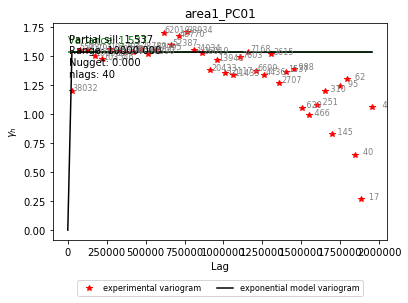

Calculating statistics on variogram model fit...
Q1 = 1.5010672714651563
Q2 = 132.90857193771802
cR = 74.03727482909663 

PC02
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.9301645135469053
Full Sill: 0.9301645135469053
Range: 10000
Nugget: 0.0 



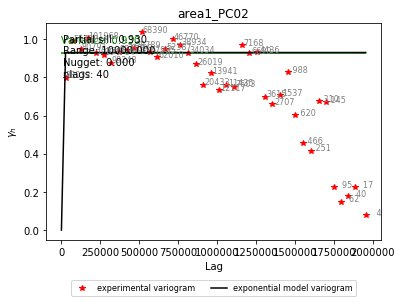

Calculating statistics on variogram model fit...
Q1 = 0.8286852432492487
Q2 = 324.58736634660966
cR = 109.43222385857632 

PC03
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.6864355588446182
Full Sill: 0.6864355588446182
Range: 10000
Nugget: 0.0 



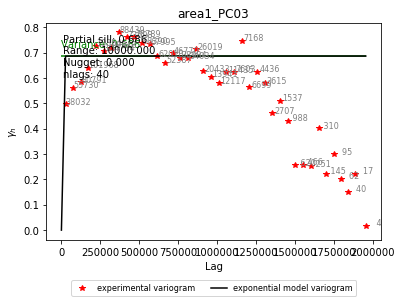

Calculating statistics on variogram model fit...
Q1 = 1.2724922152579508
Q2 = 1068.76153709182
cR = 265.90985591333765 

PC04
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.558221113307297
Full Sill: 0.558221113307297
Range: 10000
Nugget: 0.0 



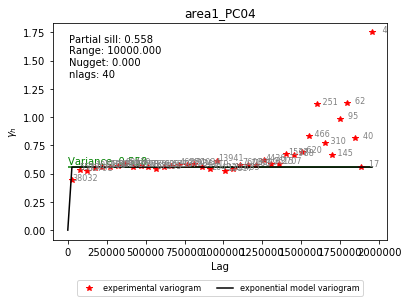

Calculating statistics on variogram model fit...
Q1 = 0.5382509998260443
Q2 = 1269.1555644616158
cR = 256.788140712202 

PC05
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.45387034094293754
Full Sill: 0.45387034094293754
Range: 10000
Nugget: 0.0 



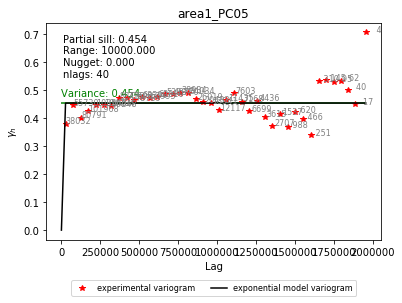

Calculating statistics on variogram model fit...
Q1 = 0.3616548613622644
Q2 = 593.6874821531565
cR = 97.66603162544706 

PC06
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.31420060711392633
Full Sill: 0.31420060711392633
Range: 10000
Nugget: 0.0 



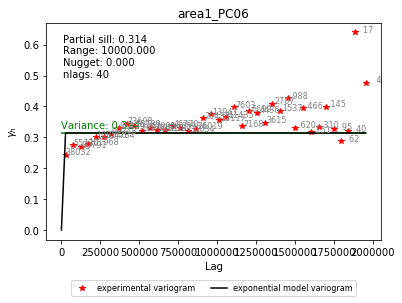

Calculating statistics on variogram model fit...
Q1 = 0.8714211717261773
Q2 = 1733.965973249597
cR = 197.47014116661884 

PC07
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.2852093591978331
Full Sill: 0.2852093591978331
Range: 10000
Nugget: 0.0 



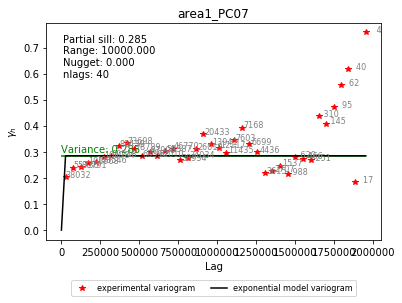

Calculating statistics on variogram model fit...
Q1 = 0.32380671929651905
Q2 = 138.97274954356212
cR = 14.366377328906268 

PC08
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.21977225918274856
Full Sill: 0.21977225918274856
Range: 10000
Nugget: 0.0 



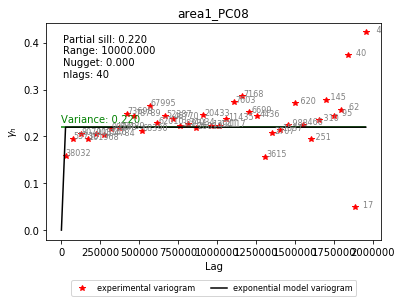

Calculating statistics on variogram model fit...
Q1 = 0.09063652227485217
Q2 = 437.71687980875544
cR = 34.86743607511734 

PC09
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.21086400615026443
Full Sill: 0.21086400615026443
Range: 10000
Nugget: 0.0 



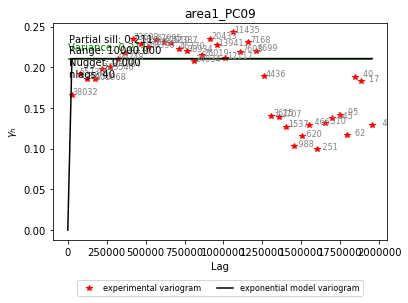

Calculating statistics on variogram model fit...
Q1 = 0.25011592021268503
Q2 = 392.38724604179583
cR = 29.989635144573302 

PC10
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.14066762732955992
Full Sill: 0.14066762732955992
Range: 10000
Nugget: 0.0 



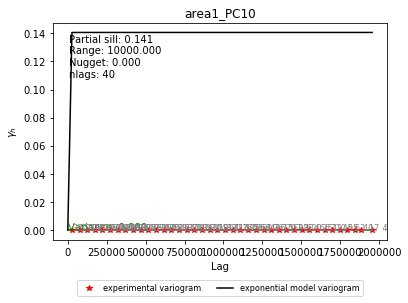

Calculating statistics on variogram model fit...
Q1 = 5.442683622189393e-16
Q2 = 2.4525115105517676e-27
cR = 1.2504290726465895e-28 

PC11
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.047935683592566065
Full Sill: 0.047935683592566065
Range: 10000
Nugget: 0.0 



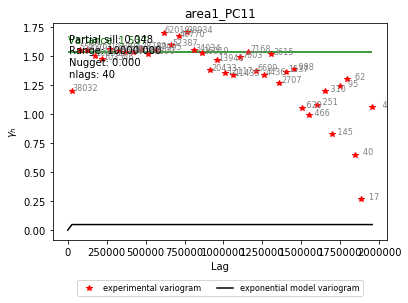

Calculating statistics on variogram model fit...
Q1 = 8.499482557099856
Q2 = 4261.256274928993
cR = 74.0372748263101 

PC12
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.01767330986677417
Full Sill: 0.01767330986677417
Range: 10000
Nugget: 0.0 



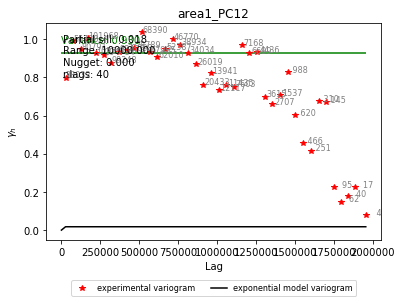

Calculating statistics on variogram model fit...
Q1 = 6.011883313384856
Q2 = 17083.367635210143
cR = 109.43222388167237 

PC13
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.005452319195206302
Full Sill: 0.005452319195206302
Range: 10000
Nugget: 0.0 



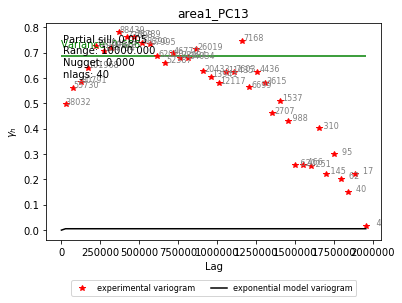

Calculating statistics on variogram model fit...
Q1 = 14.277901583726749
Q2 = 134554.83740615152
cR = 265.90985584531387 

PC14
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.00011932095848339715
Full Sill: 0.00011932095848339715
Range: 10000
Nugget: 0.0 



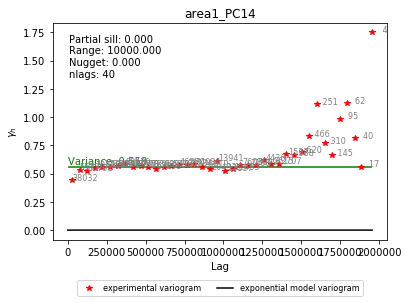

Calculating statistics on variogram model fit...
Q1 = 36.815407156696956
Q2 = 5937510.40249707
cR = 256.7881407401362 



In [170]:
# Initialize empty dictionary
variograms = {}

# Loop though the diiferent principal components
for component in mineralogy_pca_df.columns.tolist()[:-1]:
    print(component)
    # Subset principal component to use
    data = mineralogy_pca_df.iloc[:, int(component[-1])-1].values
    variograms[component] = \
        OrdinaryKriging(X, Y, data,
                        variogram_model='exponential',
                        variogram_parameters=variogram_model_parameters[component],
                        nlags=n_lags,
                        verbose=True,
                        enable_statistics=True,
                        enable_plotting=True,
                        weight=True,
                        saveplot=True,
                        coordinates_type='euclidean',
                        saveloc="../_FIGURES/variograms/",
                        principal_component=component,
                        pluton=group_name)
    
# NOTE that ideally Q1 is close to zero, Q2 is close to 1, and cR is as small as possible.

## Leave One Out Cross Validation (LOOCV) of PCA
____

In [ ]:
# If you have run the cross validation before you can load the results by
# running this cell and don't have to run the next cell anymore.
CV_results = preproc.load_obj("CV_results")

**The error below should be fixed now. --> Confirmed, but other error due to NaN values? --> Actual error is also related to linalg error from above**

**The cv_param°dict has been rewritten so that the parameters can be set for each PC.  
Was not sure about the numbers of PCs that you are going to use so I quickly created a loop since the parameters you use aree the same over all PCs (except for variogram_model_parameters).**

**Also made a small change in the function that gets called.  
Basically what happened was that a list was being passed with one item whereas it just expected that one item (without being in a list).  
So just added 'list_name[0]' in the function instead of 'list_name' and all should be good now.**

In [48]:
# Use this cross validation to check the hyper-parameters of your chosen variogram model 
# such as the search_radius, variogram_model, lag_bins etc.

# Cross validation parameter dictionary to use
# You can remove or add options here which will decrease or increase the number 
# of combinations of parameters the cross validation will run
cv_param_dict = {}

for component in mineralogy_pca_df.columns.tolist()[:-1]:
    cv_param_dict[component] = {"method": ["ordinary"],
                                "variogram_model": ["spherical", "exponential"],
                                "variogram_model_parameters": [variogram_model_parameters[component]],
                                "nlags": [n_lags],
                                "weight": [True],
                                "n_closest_points": [number_of_control_points],
                                "search_radius": [critical_distance, range_[0], max_lag_distance]
                                }

# The CV function below uses parallel processing to speed things up
# Your CPU will thus reach 100% probably
# To reduce the number of parallel processes to use you can change the following value
# Defaults to -1 to use all available CPU cores; change to number between 1 and 8 e.g. 
# depending on how many cores your CPU has
n_jobs = -1 

In [50]:
# Run CV and get estimators (using default MSE scorer)
estimators = loocv.perform_loocv(mineralogy_pca_df,
                                 
                                 coordinates_utm,
                                 cv_param_dict,
                                 n_jobs=n_jobs)

Fitting 1623 folds for each of 6 candidates, totalling 9738 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   57.8s


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# Convert estimators to dict of dataframes
CV_results = loocv.convert_scores_to_df(estimators)

In [ ]:
# E.g. check CV_results for PC01
# Check column 'mean_test_score' for results
# lower values are better since the scorer used is the Mean Squared Error (MSE)
CV_results["PC01"]

In [ ]:
# Save CV_results to pickle file for easy use later
preproc.save_obj(CV_results, "CV_results")

In [ ]:
# Quick look at best results per PC
loocv.print_best_scores(CV_results)

## Calculating predictions for best model
____

In [115]:
estimators_final = {}

for component in mineralogy_pca_df.columns:
    for radius in [critical_distance, range_[0]]:
        for variable_to_fit in ["estimates", "variances"]:

            estimators_final[f"{component}_{radius}_{variable_to_fit}"] = \
                Krige(method='ordinary',
                      variogram_model=variogram_model,
                      variogram_model_parameters=variogram_model_parameters[component],
                      nlags=n_lags,
                      weight=True,
                      n_closest_points=number_of_control_points,
                      search_radius=radius,
                      variable_to_fit=variable_to_fit)

In [116]:
# Run this cell if you have previously run the next cell and saved its outcome
kriging_predictions = preproc.load_obj("kriging_predictions")

FileNotFoundError: [Errno 2] No such file or directory: '../_DATA/_obj/kriging_predictions.pkl'

In [ ]:
# You can again change the n_jobs to lower the #CPU cores used for parallel processing

kriging_predictions = {}

for component in mineralogy_pca_df.columns:
    for radius in [critical_distance, range_[0]]:
        for variable_to_fit in ["estimates", "variances"]:
            
            kriging_predictions[f"{component}_{radius}_{variable_to_fit}"] = \
                cross_val_predict(estimators_final[f"{component}_{radius}_{variable_to_fit}"], 
                                  X=np.stack((coordinates_utm["X"],
                                              coordinates_utm["Y"]), axis=1),
                                  y=mineralogy_pca_df[component],
                                  cv=number_of_control_points,
                                  n_jobs=-1,
                                  verbose=5)

In [ ]:
preproc.save_obj(kriging_predictions, "kriging_predictions")

## Calculate clr solutions
____

In [ ]:
kriging_estimates_df = {}

for radius in [critical_distance, range_[0]]:
    temp = {}
    
    for component in mineralogy_pca_df.columns:
        key = f"{component}_{radius}_estimates"
        temp[key] = kriging_predictions[key]

    kriging_estimates_df[f"{radius}"] = pd.DataFrame.from_dict(temp)
    kriging_estimates_df[f"{radius}"].index = mineralogy_pca_df.index
    kriging_estimates_df[f"{radius}"].columns = mineralogy_pca_df.columns
    
    print(f"{radius}")
    kriging_estimates_df[f"{radius}"].head()

In [ ]:
kriging_variances_df = {}


for radius in [critical_distance, range_[0]]:
    temp = {}
    
    for component in mineralogy_pca_df.columns:
        key = f"{component}_{radius}_variances"
        temp[key] = kriging_predictions[key]
        
    kriging_variances_df[f"{radius}"] = pd.DataFrame.from_dict(temp)
    kriging_variances_df[f"{radius}"].index = mineralogy_pca_df.index
    kriging_variances_df[f"{radius}"].columns = mineralogy_pca_df.columns
    
    print(f"{radius}")
    kriging_variances_df[f"{radius}"].head()

In [ ]:
kriging_variances_mean_df = {}

for radius in [critical_distance, range_[0]]:
    kriging_variances_mean_df[f"{radius}"] = \
        kriging_variances_df[f"{radius}"].mean(axis=0)

    print(f"{radius}")
    kriging_variances_mean_df[f"{radius}"]

In [ ]:
kriging_estimates_clr = {}

for ncomp in range(mineralogy_pca_df.shape[1]):
    for radius in [critical_distance, range_[0]]:

        kriging_estimates_clr[f"{ncomp}_{radius}"] = \
            postproc.reverse_pca(mineralogy_pca, 
                                 kriging_estimates_df[f"{radius}"],
                                 mineralogy_clr,
                                 n_comp=ncomp)

In [ ]:
solutions_clr = {}

for ncomp in range(mineralogy_pca_df.shape[1]):
    for radius in [critical_distance, range_[0]]:

        solutions_clr[f"{ncomp}_{radius}"] = \
            pd.DataFrame(kriging_estimates_clr[f"{ncomp}_{radius}"], 
                         index=mineralogy_clr.index, 
                         columns=mineralogy_clr.columns)

In [44]:
residuals_clr = {}

for ncomp in range(mineralogy_pca_df.shape[1]):
    for radius in [critical_distance, range_[0]]:

        residuals_clr[f"{ncomp}_{radius}"] = \
            mineralogy_clr.subtract(solutions_clr[f"{ncomp}_{radius}"])

In [ ]:
for ncomp in range(mineralogy_pca_df.shape[1]):
    for radius in [critical_distance, range_[0]]:
        temp = pd.merge(residuals_clr[f"{ncomp}_{radius}"], 
                        pd.DataFrame(nvalues_control_points[radius], 
                                     columns=["n_closest_points"]), 
                        left_index=True, 
                        right_index=True)\
                 .sort_values("n_closest_points")
        
        temp.to_excel(f"../_RESULTS/residuals_clr_{ncomp}_{radius}.xlsx")

In [ ]:
preproc.save_obj(residuals_clr, "residuals_clr")

In [62]:
preproc.save_obj(nvalues_control_points, "nvalues_control_points")

## Error budget
____

In [45]:
# A = mean squared prediction error
# B = nugget
# C = non-explained variance of model
error_budget = {}

for radius in [critical_distance, range_[0]]:
    for ncomp in range(mineralogy_pca_df.shape[1]):
        A = np.mean(np.sum(residuals_clr[f"{ncomp}_{radius}"] ** 2, axis=1), axis=0)
        B = np.array(nugget_)[:ncomp].sum()
        C = A - B

        error_budget[f"{ncomp}_{radius}"] = [A, B, C]

In [ ]:
error_budget_df = \
    ttest.convert_summary_test_results_to_df(error_budget, 
                                             variable_names=["MSPE", 
                                                             "Nugget", 
                                                             "Non-expl var of model"], 
                                             order=["search_radius", 
                                                    "#PCs"])
error_budget_df

In [63]:
error_budget_df.to_excel("../_RESULTS/Error_budget/error_budget.xlsx")

## Contour plots
____

In [49]:
nvalues_critical_distance = \
    variograms["PC01"].determine_mask_array(grid[0], 
                                            grid[1], 
                                            search_radius=critical_distance)
mask_critical_distance = nvalues_critical_distance < 3
mask_critical_distance.shape

(130, 2)
(270039, 2)
539 501


(501, 539)

In [ ]:
mask_critical_distance[mask_critical_distance == 1].sum()

In [ ]:
non_masked_grid_nodes = \
    grid[0].shape[0] * grid[1].shape[0] \
    - mask_critical_distance[mask_critical_distance == 1].sum()

In [52]:
grid_cell_spacing = grid[0][1] - grid[0][0]
grid_cell_area = grid_cell_spacing ** 2

In [53]:
# Pluton area in m²
pluton_area_m2 = non_masked_grid_nodes * grid_cell_area

# Pluton area in km²
pluton_area_km2 = pluton_area_m2 / 1_000_000

In [ ]:
pluton_area_km2

____

In [55]:
interpolated_dict = preproc.load_obj("interpolated_dict")

In [126]:
%%time
interpolated_parallel = Parallel(n_jobs=-1)(delayed(
    OK_model.execute)('masked', 
                     grid[0], 
                     grid[1],
                     mask_critical_distance,
                     n_closest_points=number_of_control_points, 
                     search_radius=range_[0], 
                     backend='loop') for component, OK_model in variograms.items())

Wall time: 52.3 s


In [127]:
interpolated_dict = {}
for i, item in enumerate(interpolated_parallel, start=1):
    interpolated_dict[f"PC0{i}"] = item

In [128]:
preproc.save_obj(interpolated_dict, "interpolated_dict")

In [56]:
# Number of PCs to use for reverse calculations
n_comp

interpolated_array = postproc.convert_grid_to_array_of_scores(interpolated_dict)

interpolated_reverse_pca = postproc.reverse_pca(pca_BM, 
                                                interpolated_array, 
                                                mineralogy_clr, 
                                                n_comp=n_comp)

interpolated_reverse_clr = postproc.reverse_clr(interpolated_reverse_pca, 
                                                mineralogy_clr)

1
2
3
(3, 501, 539)


C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\main\lib\site-packages\IPython\core\interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [57]:
# Check if the number of points based on the specified grid is equal to
# the sum of the number of masked points and the number of interpolated points
assert grid[0].shape[0] * grid[1].shape[0] == np.sum(np.isclose(interpolated_reverse_clr.sum(axis=1), 0.0)) + \
                                              np.sum(np.isclose(interpolated_reverse_clr.sum(axis=1), 100.0))

In [58]:
interpolated_modal = {}
for mineral in interpolated_reverse_clr.columns.tolist():
    interpolated_modal[mineral] = np.reshape(interpolated_reverse_clr.loc[:, mineral].values, 
                                             (grid[1].shape[0], grid[0].shape[0]))

In [132]:
# If you get an error related to an non-esixting save location
# Please first create a folder on your pc with the same name that 
# you used for the variable 'group_name'

for mineral, interpolation in interpolated_modal.items(): 
    for variable in ["estimates"]:
        print(interpolation.shape)
        plots.plot_contour_map(interpolation,
                               grid,
                               coordinates,
                               group_name,
                               variable=variable,
                               title=f"{mineral} radius={range_[0]}m {variable} masked {critical_distance}m",
                               show_plot=False,
                               single_mineral=True,
                               mineral=mineral,                               
                               label_pos = (0.03, 0.94),
                               skip_xaxis_label=2,
                               skip_yaxis_label=2,
                               skip_xaxis_start=1,
                               skip_yaxis_start=1,)

(501, 539)
Q
(501, 539)
P
(501, 539)
K
(501, 539)
Others


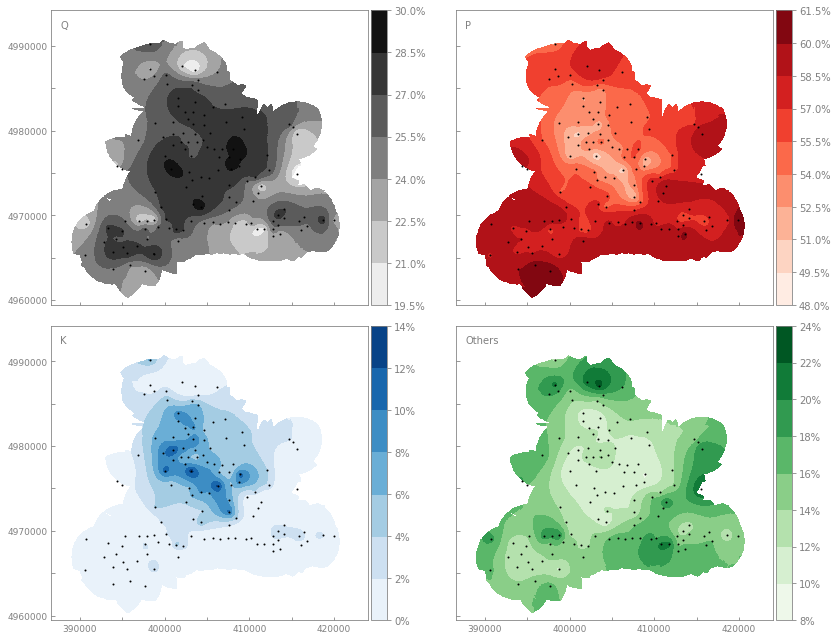

In [133]:
# Specify how many rows and columns you want to use in the following figure
# This will ofcourse depend an the number of variables you would like to plot
# You can also set the figure size

# Figure with single mineral maps as subplots
plots.plot_contour_map_all(interpolated_modal,
                           grid_wide,
                           coordinates_utm,
                           group_name,
                           title=f"radius={range_[0]}m masked {critical_distance}m",
                           show_plot=True,
                           label_pos = (0.03, 0.94),
                           skip_xaxis_label=2,
                           skip_yaxis_label=2,
                           skip_xaxis_start=1,
                           skip_yaxis_start=1,
                           figsize=(12, 9),
                           ncols=n_cols,
                           nrows=n_rows,
                           sharex=True,
                           sharey=True)

## Biplots
____

Not relevant for now

## Simulations
____

Not relevant for now